In [41]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./dogs-cats-mini//"))

['dog.8011.jpg', 'cat.5077.jpg', 'dog.7322.jpg', 'cat.2718.jpg', 'cat.10151.jpg', 'cat.3406.jpg', 'dog.1753.jpg', 'cat.4369.jpg', 'cat.7660.jpg', 'dog.5535.jpg', 'cat.8553.jpg', 'cat.9895.jpg', 'cat.1211.jpg', 'dog.3144.jpg', 'dog.775.jpg', 'dog.11102.jpg', 'cat.6218.jpg', 'dog.11664.jpg', 'dog.3622.jpg', 'cat.1577.jpg', 'cat.12020.jpg', 'dog.5253.jpg', 'cat.7106.jpg', 'cat.8235.jpg', 'cat.952.jpg', 'dog.9469.jpg', 'dog.1035.jpg', 'cat.3360.jpg', 'cat.11529.jpg', 'cat.10637.jpg', 'dog.6982.jpg', 'dog.8777.jpg', 'dog.7444.jpg', 'cat.5711.jpg', 'cat.946.jpg', 'cat.3374.jpg', 'dog.1021.jpg', 'dog.6996.jpg', 'cat.10623.jpg', 'dog.8763.jpg', 'cat.5705.jpg', 'dog.7450.jpg', 'dog.12379.jpg', 'dog.11670.jpg', 'dog.4159.jpg', 'cat.1563.jpg', 'dog.3636.jpg', 'cat.12034.jpg', 'dog.2528.jpg', 'cat.7112.jpg', 'dog.5247.jpg', 'cat.8221.jpg', 'dog.10208.jpg', 'dog.5521.jpg', 'cat.7674.jpg', 'cat.8547.jpg', 'cat.9881.jpg', 'dog.761.jpg', 'dog.3150.jpg', 'cat.1205.jpg', 'dog.11116.jpg', 'cat.9659.jpg',

In [8]:
import shutil
import os

In [70]:
FAST_RUN = True
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [42]:
filenames = os.listdir("./dogs-cats-mini/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [43]:
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


In [44]:
df.tail()

,filename,category
24995,dog.8008.jpg,1
24996,dog.1992.jpg,1
24997,dog.12412.jpg,1
24998,cat.2701.jpg,0
24999,cat.10148.jpg,0


<Axes: xlabel='category'>

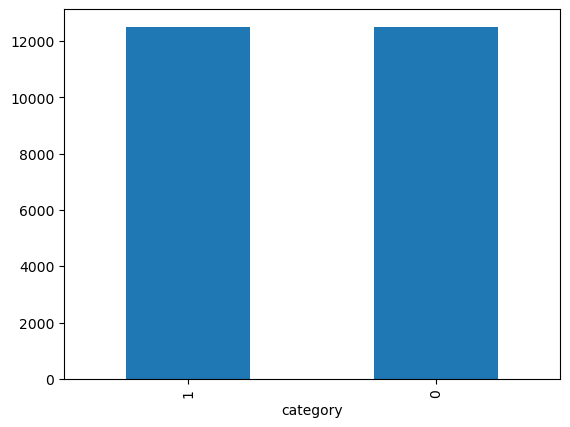

In [45]:
df['category'].value_counts().plot.bar()

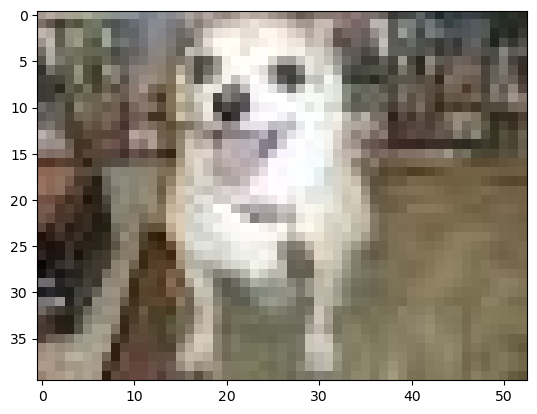

In [49]:
sample = random.choice(filenames)
image = load_img("./dogs-cats-mini/"+sample)
plt.imshow(image)

In [50]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 29, 29, 64)      

In [51]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [52]:
earlystop = EarlyStopping(patience=10)

In [53]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [54]:
callbacks = [earlystop, learning_rate_reduction]

In [55]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [56]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

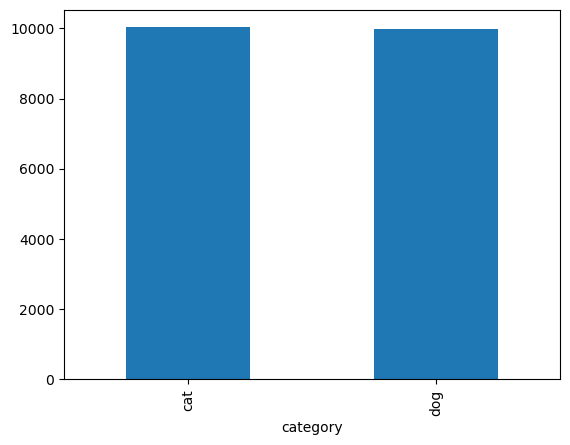

In [57]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

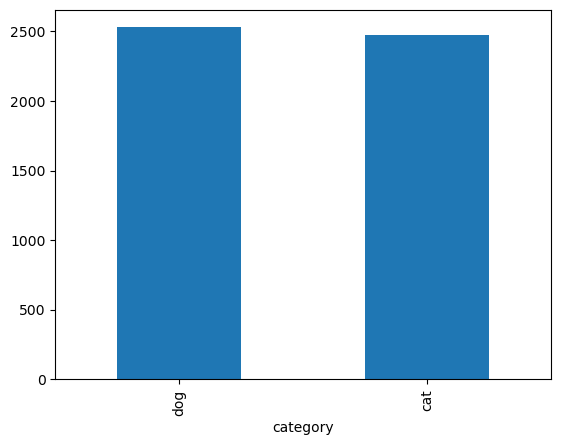

In [58]:
validate_df['category'].value_counts().plot.bar()

In [59]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [63]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dogs-cats-mini/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [65]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dogs-cats-mini/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [67]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./dogs-cats-mini/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


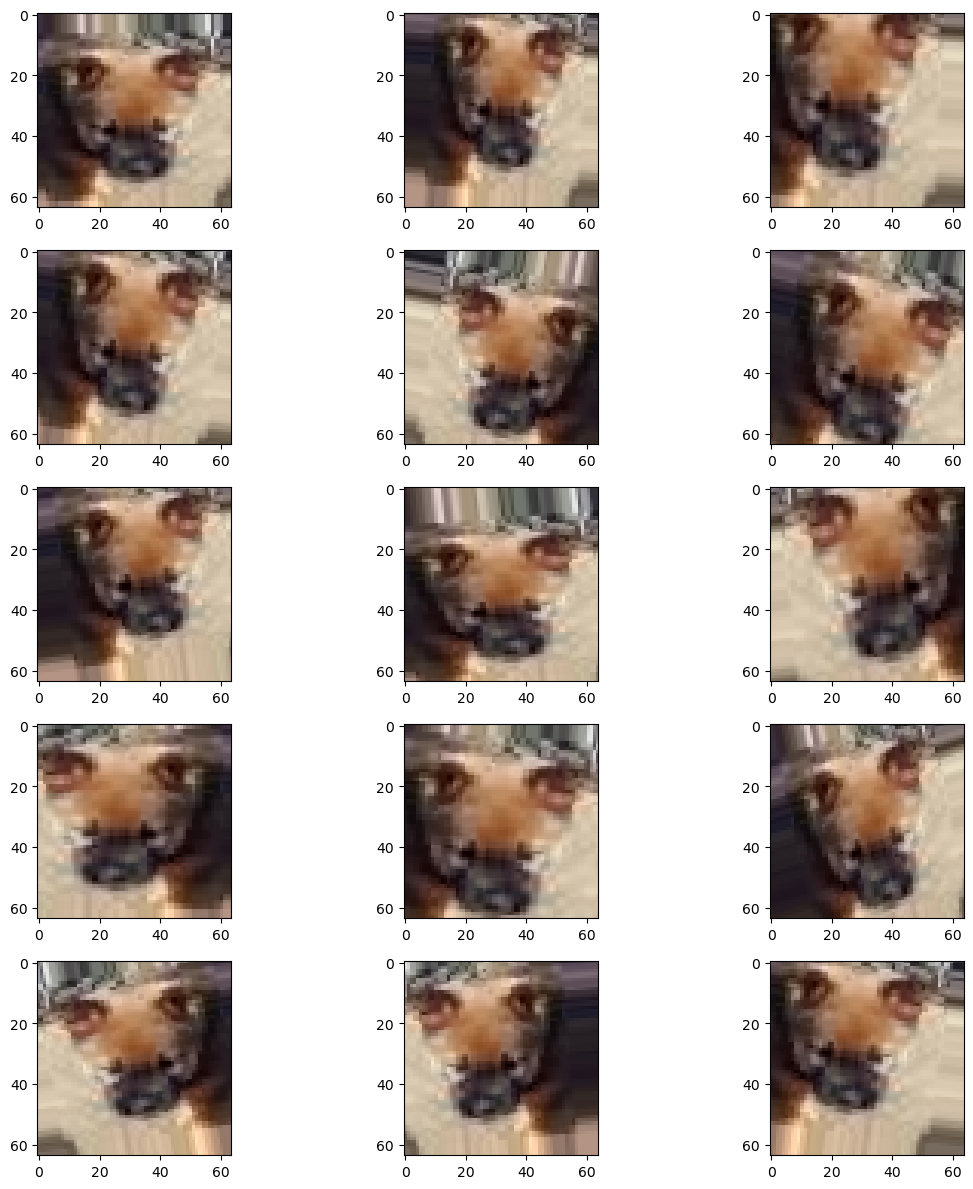

In [68]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [72]:
epochs=10 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10


/var/folders/2n/z74nb9cn4kl60b3mjj5lgz140000gn/T/ipykernel_39212/1511987806.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - 40s 30ms/step - loss: 0.5302 - accuracy: 0.7410 - val_loss: 0.4919 - val_accuracy: 0.7702 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 42s 31ms/step - loss: 0.5157 - accuracy: 0.7506 - val_loss: 0.5127 - val_accuracy: 0.7477 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 39s 29ms/step - loss: 0.5032 - accuracy: 0.7585 - val_loss: 0.3960 - val_accuracy: 0.8228 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - 37s 28ms/step - loss: 0.4837 - accuracy: 0.7687 - val_loss: 0.5084 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - 37s 28ms/step - loss: 0.4776 - accuracy: 0.7713 - val_loss: 0.4096 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 6/10
1333/1333 [==============================] - 42s 32ms/step - loss: 0.4678 - accuracy: 0.7823 - val_loss: 0.4665 - val_accuracy: 0.7948 - lr: 0.0010
Epoch 7/10
1333/1333 [==============================] - 4

In [73]:
model.save_weights("model.h5")

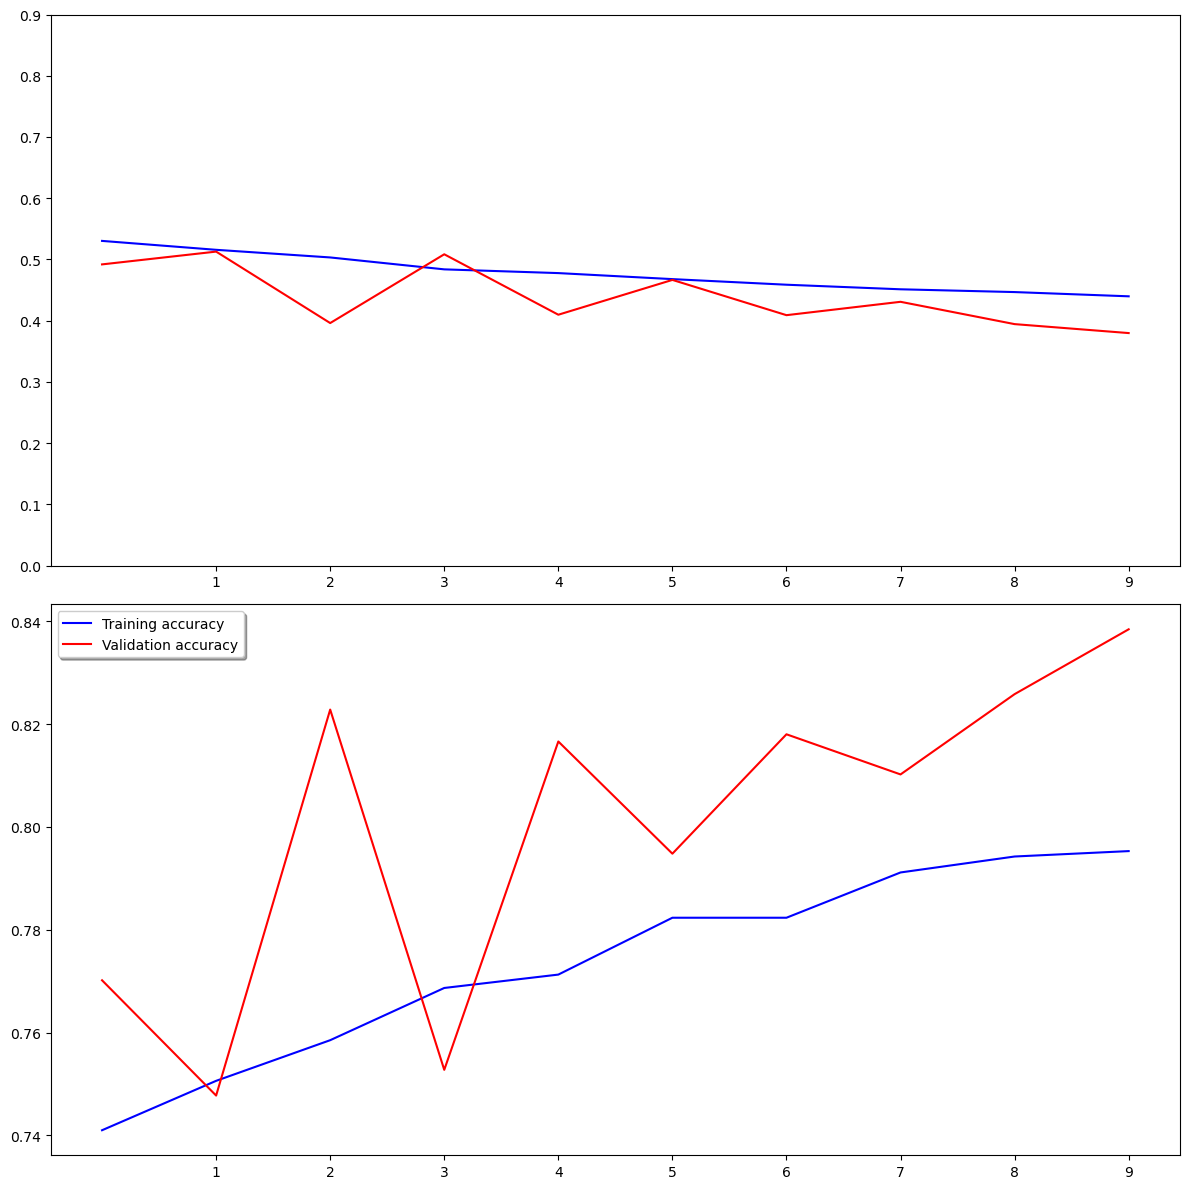

In [81]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [77]:
test_filenames = os.listdir("./input/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [78]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./input/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1000 validated image filenames.


In [90]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

67/67 [==============================] - 1s 9ms/step


In [91]:
test_df['category'] = np.argmax(predict, axis=-1)

In [92]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [93]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<Axes: xlabel='category'>

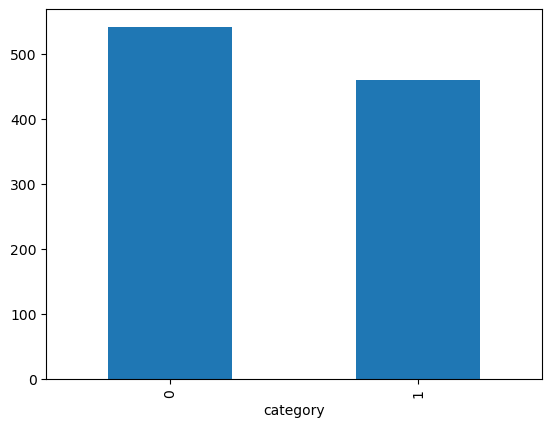

In [94]:
test_df['category'].value_counts().plot.bar()

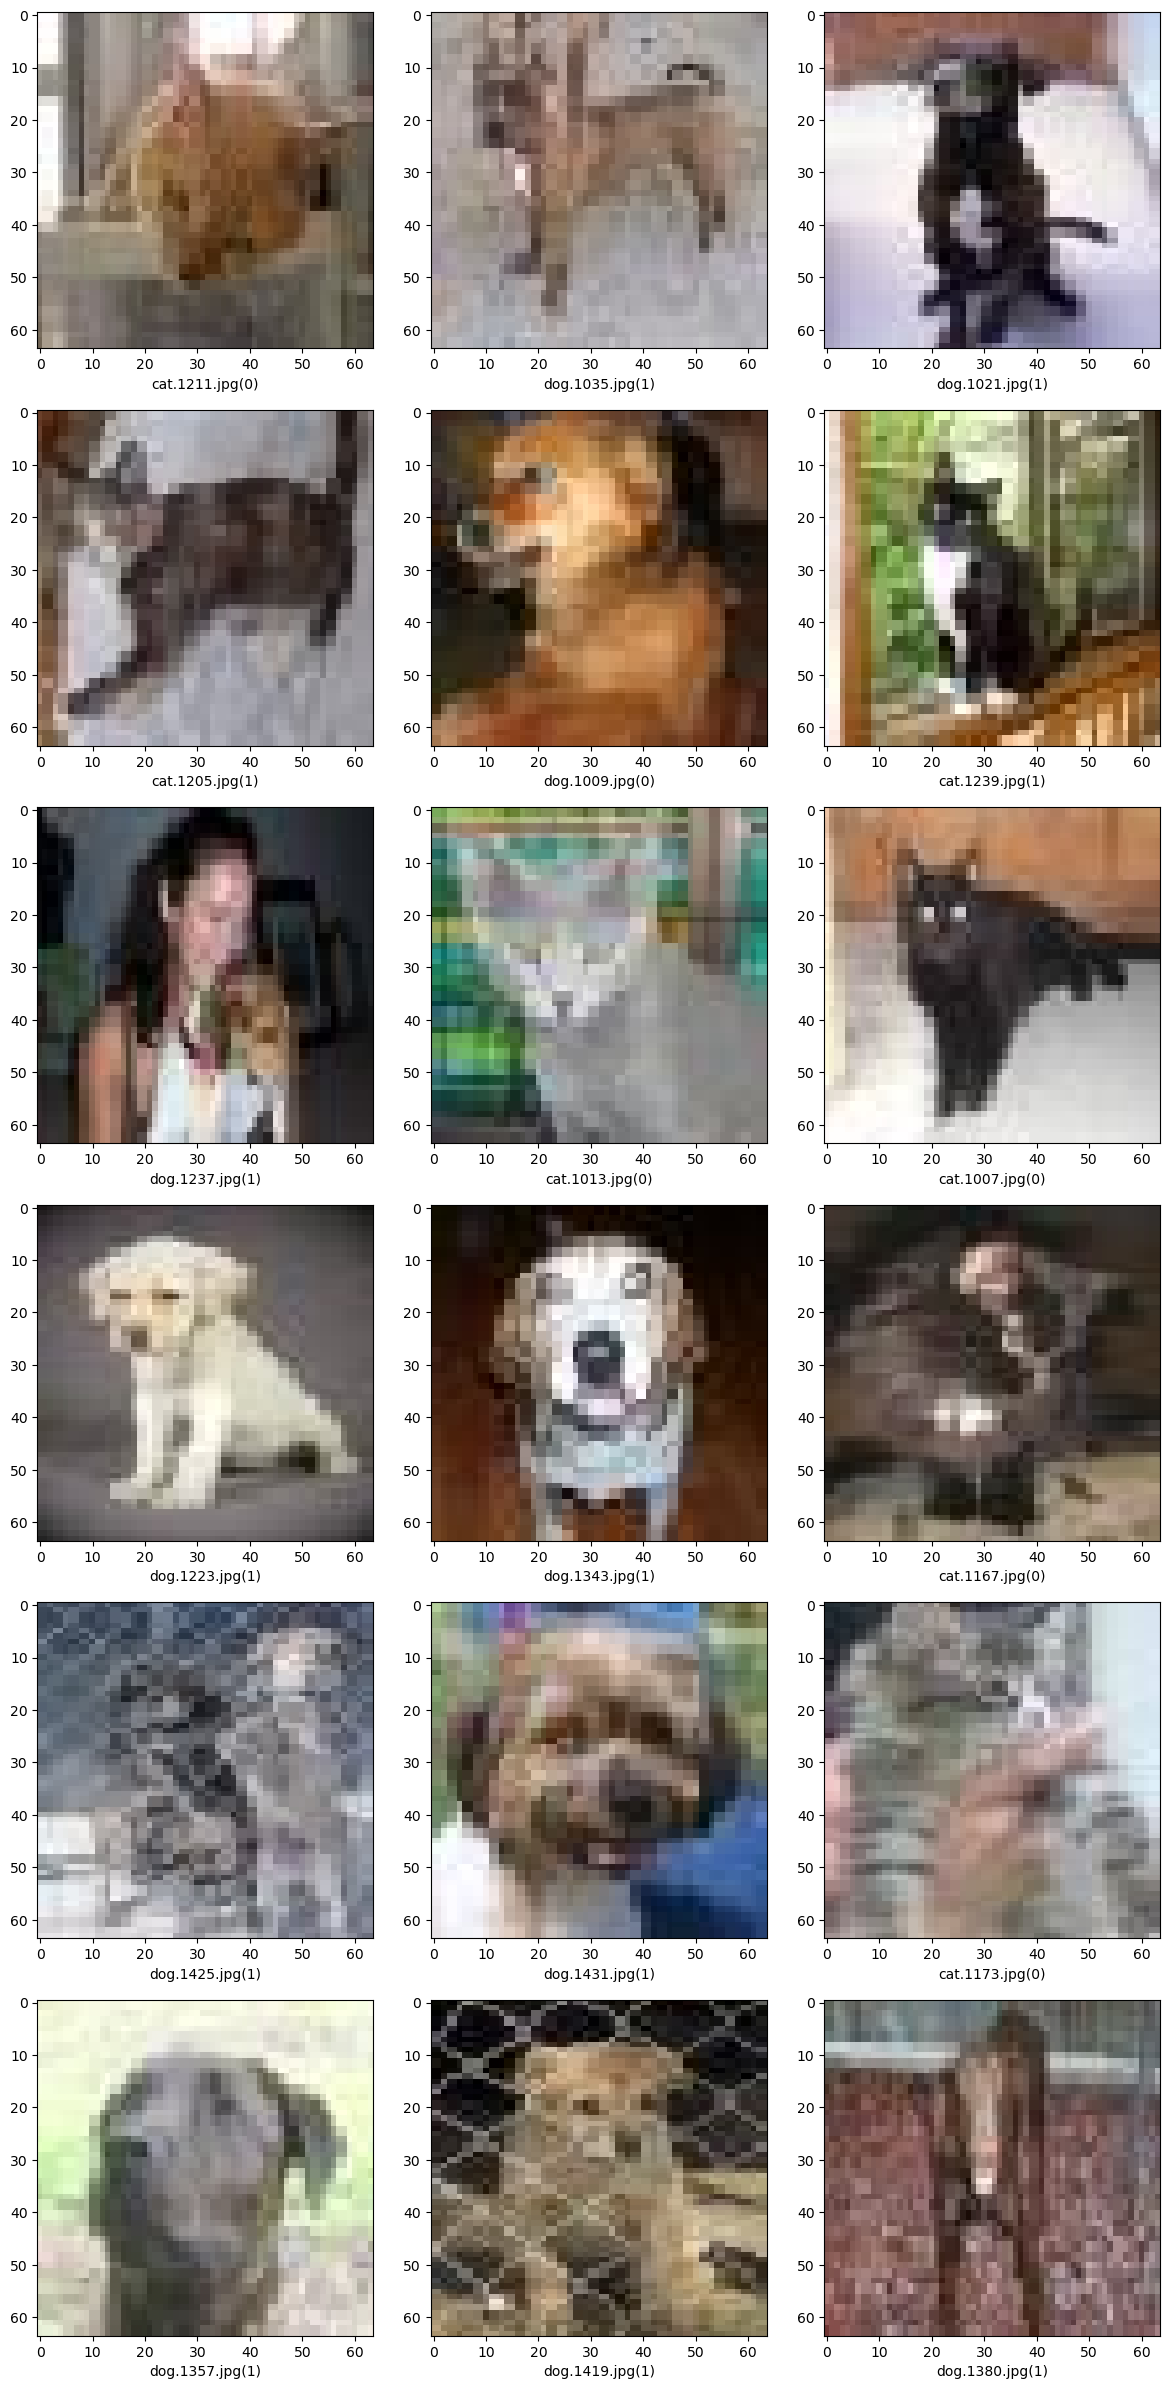

In [95]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./input/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [89]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)